In [22]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import signal
from tools import *

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread 

# Import auryn tools
sys.path.append(os.path.expanduser("~/auryn/tools/python/"))
from auryntools import *
from matplotlib import animation, rc
from IPython.display import HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import tools
import elephant
import quantities as pq
from neo.core import SpikeTrain
import viziphant
from pyvis.network import Network
import networkx as nx
import pandas as pd

In [23]:
dure_simu = 900
begining_presentation = 0
duree_pattern = 0.05
time_step = 0.1
auryn_tstep = 0.0001
spls = dure_simu/time_step

In [24]:
deb = 100
dur = 2
beg = int(deb//time_step)
end = beg+int(dur//time_step)

In [42]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("~/data/sim_network/sim_10Hz_simple_se0.4") # Set this to your data path
prefix = "rf1"

nb_neurons = 4096

In [43]:
#datadir_sigal = os.path.expanduser("~/data/sim_network/sim_10Hz_cons_4h_1pat_mrco_5_demonstration") # Set this to your data path
datadir_sigal = datadir

In [44]:
all_times = np.genfromtxt(datadir_sigal+'/pattern_time', delimiter=' ')
nb_pattern = len(set(all_times[:,1]))
signals = np.zeros((nb_pattern,int(dure_simu//time_step)+1))
signals_times = [[] for i in range(nb_pattern)]
for time,kind in all_times:
    signals_times[int(kind)].append(time*auryn_tstep)
    signals[int(kind),int((time*auryn_tstep)//time_step):int((time*auryn_tstep+(duree_pattern))//time_step)]=1
signals_times = np.array(signals_times)

OSError: /users/nsr/saighi/data/sim_network/sim_10Hz_simple_se0.4/pattern_time not found.

# Find low rank structure in spiking activity

In [45]:
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

Oops! Could not open file /users/nsr/saighi/data/sim_network/sim_10Hz_simple_se0.4/rf1.0.e.spk. Invalid file name.


ValueError: 

In [46]:
#spkext = pd.read_csv("%s/%s.%i.spikes_ext.txt"%(datadir,prefix,0),delimiter=' ').values
extfiles  = ["%s/%s.%i.ext.spk"%(datadir,prefix,i) for i in range(1)]
sfo_ext = AurynBinarySpikeView(extfiles)

Oops! Could not open file /users/nsr/saighi/data/sim_network/sim_10Hz_simple_se0.4/rf1.0.ext.spk. Invalid file name.


ValueError: 

In [47]:
rateE  = np.mean([pd.read_csv("%s/%s.%i.e.prate"%(datadir,prefix,2),delimiter=' ').values for i in range(num_mpi_ranks)],axis=0)

FileNotFoundError: [Errno 2] No such file or directory: '/users/nsr/saighi/data/sim_network/sim_10Hz_simple_se0.4/rf1.2.e.prate'

In [48]:
time_axis = np.linspace(0,dure_simu,int(dure_simu//time_step))
rateE= rateE[:,1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

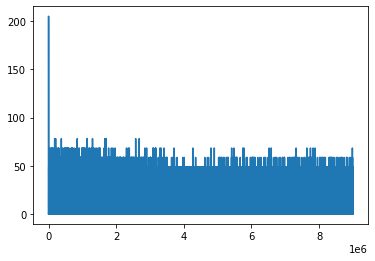

In [40]:
#plt.plot(time_axis,rateE)
plt.plot(rateE)

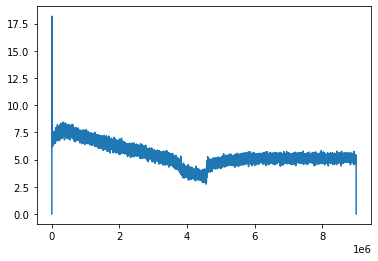

In [41]:
win = signal.windows.hann(1000)
plt.plot(np.convolve(rateE,win)/ sum(win))

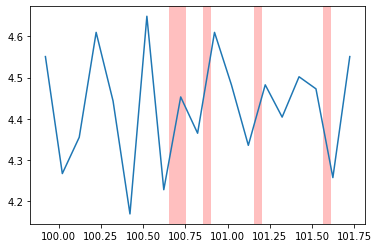

In [183]:
plt.plot(time_axis[beg:end],rateE[beg:end])
some_signals = signals_times[0][ (signals_times[0]<(deb+dur) ) & (signals_times[0]>deb)]
for sig in some_signals:
    plt.axvspan(sig, sig+duree_pattern, facecolor='red', alpha=0.25)

In [184]:
some_signals = signals_times[0][ (signals_times[0]<(deb+dur) ) & (signals_times[0]>deb)]

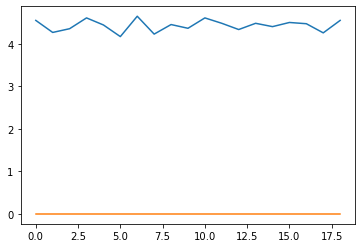

In [185]:
plt.plot(rateE[beg:end])
plt.plot(signals[0][beg:end]*10)

In [186]:
rateI  = np.mean([pd.read_csv("%s/%s.%i.i2.prate"%(datadir,prefix,i),delimiter=' ' ) for i in range(num_mpi_ranks)],axis=0)
time_axis_I = rateI[:,0]
rateI= rateI[:,1]

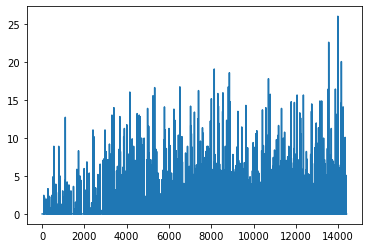

In [16]:
plt.plot(time_axis_I,rateI)

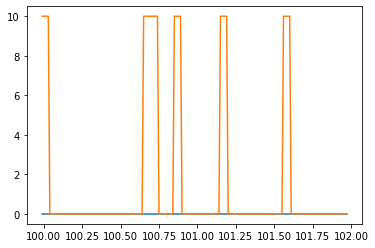

In [17]:
plt.plot(time_axis[beg:end],rateI[beg:end])
plt.plot(time_axis[beg:end],signals[0][beg:end]*10)

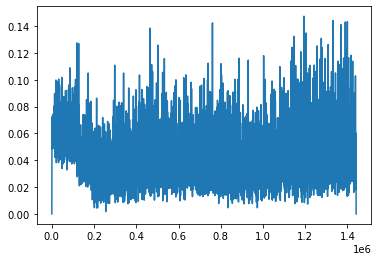

In [18]:
win = signal.windows.hann(1000)
plt.plot(np.convolve(rateE,win)/ sum(win))

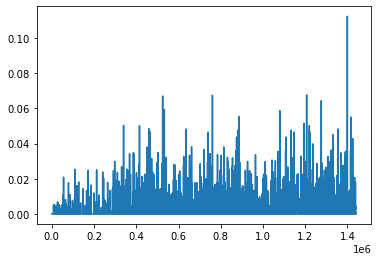

In [19]:
win = signal.windows.hann(1000)
plt.plot(np.convolve(rateI,win)/ sum(win))

## Raster Plot illustrant la reaction du system

In [20]:
def plot_profile(begin,end,title,nb_sample,nb_sample_ext,alpha = 1,signal = 0,more_than = 1000):

    tm_rast = begin
    time_range_rast = end
    beg_2 = int(tm_rast//time_step)
    end_2 = beg_2+int(time_range_rast//time_step)
    
    spikes_rast = np.array(sfo.get_spikes(t_start=tm_rast,t_stop=tm_rast+time_range_rast))

    ListTrains = [[] for _ in range(nb_neurons)] 
    for s in spikes_rast:
        ListTrains[int(s[1])].append(s[0])

    spikes_rast  = np.array([li for li in spikes_rast if len(ListTrains[int(li[1])])<more_than])
    np.random.seed(0)
    sample = np.random.choice(list(range(nb_neurons)),nb_sample)
    spikes_rast_sample = np.array([i for i in spikes_rast if i[1] in sample])

    spikes_rast_ext = np.array(sfo_ext.get_spikes(t_start=tm_rast,t_stop=tm_rast+time_range_rast))

    sample_ext = np.random.choice(list(range(nb_neurons)),nb_sample_ext)
    spikes_rast_sample_ext =np.array([i for i in spikes_rast_ext if i[1] in sample_ext])
    
    new_indexes = dict(zip(list(set(spikes_rast_sample[:,1])),list(range(nb_sample))))
    
    new_indexes_ext = dict(zip(list(set(spikes_rast_sample_ext[:,1])),list(range(nb_sample_ext))))
    
    colors = in_pattern(spikes_rast_sample_ext,duree_pattern, signals_times[0])
    colors = ["r" if i ==1 else "b" for i in colors]
    
    fig, axs = plt.subplots(3,figsize=(8,10),sharex=True,gridspec_kw={'height_ratios': [2,2, 1]})
    fig.suptitle(title,y = 0.92,fontsize = 15)
    
    axs[0].scatter(spikes_rast_sample_ext[:,0], 
                   [new_indexes_ext[i] for i in spikes_rast_sample_ext[:,1]],alpha = alpha, c =colors,s = 18)
    axs[0].set_ylabel("input neuron index",fontsize = 12)

    axs[1].scatter(spikes_rast_sample[:,0], 
                   [new_indexes[i] for i in spikes_rast_sample[:,1]],alpha = alpha, c="b",s = 18)
    axs[1].set_ylabel("output neuron index",fontsize = 12)

    some_signals = signals_times[0][ (signals_times[0]<(tm_rast+time_range_rast) ) & (signals_times[0]>tm_rast)]

    axs[2].plot(time_axis[beg_2:end_2],rateE[beg_2:end_2])

    for sig in some_signals:
        axs[2].axvspan(sig, sig+duree_pattern, facecolor='red', alpha=0.25)
    
    axs[2].set_ylabel("rate (Hz)",fontsize = 12)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (s)",fontsize = 12)
    #plt.ylabel("common Y",x = 0)
    

In [21]:
plot_profile(110.4,1.1,"Before learning",1500,150,more_than = 20)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [22]:
plot_profile(14385,1.1,"After learning",1500,150,more_than = 20)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [23]:
tm = 14000
time_range = 400
which_signal = 0

In [24]:
spikes = np.array(sfo.get_spikes(t_start=tm,t_stop=tm+time_range))

In [25]:
#spikes_all = np.array(sfo.get_spikes())

In [26]:
#np.savetxt("%s/e_spikes.txt"%(datadir),spikes_all)

In [27]:
times,dists = tools.SpikesDistFromPat(spikes[:,0],duree_pattern,signals_times[which_signal])

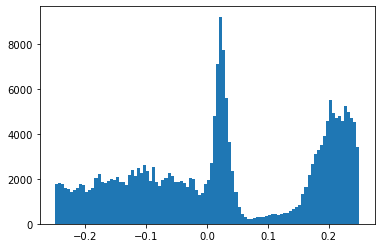

In [28]:
plt.hist(dists,bins=100);

In [29]:
ListTrains = [[] for _ in range(nb_neurons)] 
for s in spikes:
    ListTrains[int(s[1])].append(s[0])

In [30]:
len(set(spikes[:,1]))

1261

In [31]:
distancesN = SpikesDistNeurones(spikes,duree_pattern,signals_times[which_signal],window = 0.15)

In [33]:
scores = np.array([ np.sum(np.logical_and(np.array(x)[:,0]<duree_pattern,np.array(x)[:,0]>0))/len(x) for x in distancesN if len(x)>0])

### Certains neurones sont hyper actifs.

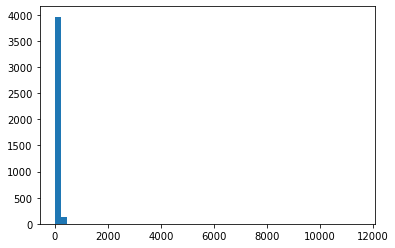

In [34]:
plt.hist(list(map(len,ListTrains)),bins=50);

### Une minorité code bien le signal

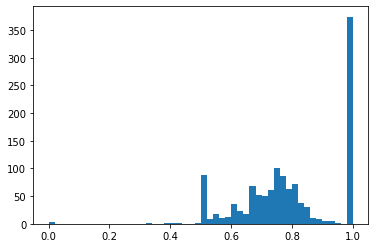

In [35]:
plt.hist(scores,bins=50);

In [36]:
not_to_fast_ones  = [ListTrains[li]  for li in range(len(ListTrains)) if len(ListTrains[li])<1000]

### Un neuron parfait ?

In [37]:
the_one = np.argmax(scores)

### Et qui fire assez souvent. Si sont firing rate était à la ramasse, on aurait pu penser 
### qu'il se serait fait attribué un bon score par accident.

In [38]:
lelu = SpikeTrain(ListTrains[the_one]*pq.s,t_start=min(ListTrains[the_one]),t_stop=max(ListTrains[the_one]))
len(ListTrains[the_one])

3

In [39]:
distTrainOne = np.array(distancesN[the_one])

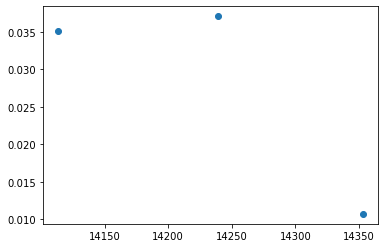

In [40]:
plt.scatter(distTrainOne[:,1],distTrainOne[:,0])

### Des bons neurones 

In [41]:
the_ones = np.where(scores>0.75)[0]

In [42]:
scatter_ones = np.sort([spike  for  n in the_ones for spike in ListTrains[n]])

In [43]:
times_ones ,dists_ones = tools.SpikesDistFromPat(scatter_ones,duree_pattern,signals_times[which_signal],window=0.2)

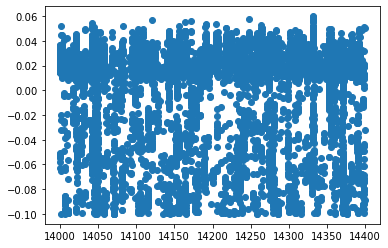

In [44]:
plt.scatter(times_ones,dists_ones)

In [221]:
trains = []
for i in the_ones:
    trains.append(ListTrains[i])
trains = np.sort(np.array([j for i in trains for j in i]))

In [222]:
lelu = SpikeTrain(trains*pq.s,t_start=min(trains),t_stop=max(trains))

In [223]:
signi_train =elephant.statistics.instantaneous_rate(lelu,1*pq.ms)

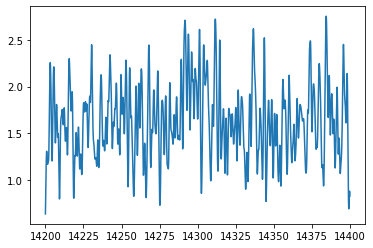

In [224]:
plt.plot(signi_train.times,signi_train/len(the_ones))
#plt.plot(time_axis[beg:end],signals[0][beg:end]*10)

# Load and analyze EE weights

In [225]:
wmatfiles  = ["%s/rf1.%i.ee.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
w = np.sum( [ mmread(wf) for wf in wmatfiles ] )

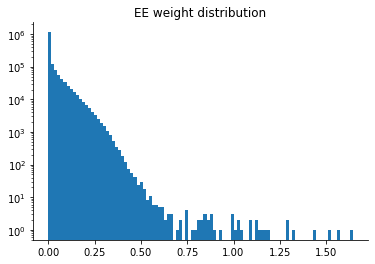

In [226]:
h1 = plt.hist(w.data, bins=100, log=True)
plt.title("EE weight distribution")
sns.despine()

In [227]:
np.mean([i for i in w.data if i !=0])

0.023796250698209266

In [228]:
connectivity_pat =[]
for n in the_ones:
    for n2 in the_ones:
        if w[n,n2] !=0:
            connectivity_pat.append([n,n2,w[n,n2]])
connectivity_pat = np.array(connectivity_pat)        

### Des neurones très connectés avec une activité liée dans le temps 

In [675]:
v_co = connectivity_pat[np.argmax(connectivity_pat[:,2])]

In [681]:
v_co[0]

784.0

In [697]:
distTrainPost = np.array(distancesN[int(v_co[1])])
distTrainPre = np.array(distancesN[int(v_co[0])])

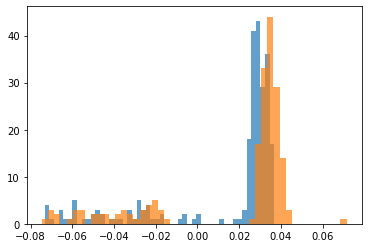

In [702]:
plt.hist(distTrainPre[:,0],bins=50,alpha = 0.7);
plt.hist(distTrainPost[:,0],bins=50,alpha = 0.7);

In [669]:
most_connected_arg = connectivity_pat[connectivity_pat[:,2].argsort()[-50:][::-1]]
most_connected= most_connected_arg[:,[0,1]].ravel().astype(int)
scores_mst =scores[most_connected]

In [670]:
net = Network(notebook=True)
net.add_nodes(most_connected)
net.add_edges(most_connected_arg)


In [703]:
#net.show("my_network.html")